In [19]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings('ignore')

In [20]:
import tensorflow
from  keras.models import Sequential, Model
from  keras.layers import Input, Dense, LeakyReLU, Activation, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, InputLayer, Flatten, BatchNormalization, Reshape, Lambda

from  keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from  keras.applications.vgg16 import VGG16, preprocess_input
#from  keras.applications import ResNet152V2,ResNet101V2,ResNet50V2 
#from  keras.applications.resnet_v2 import preprocess_input 

from  keras.optimizers import RMSprop, Adam
from  keras.preprocessing.image import load_img, ImageDataGenerator
from  keras.utils import multi_gpu_model
from IPython.display import Image 

import keras_metrics
import pandas
import ast
import numpy as np
import matplotlib.patches as patches 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageDraw,ImageFont

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras.backend as K
import numpy as np
import random

In [22]:
from skimage import color
from skimage import io

def custom_preprocess_input(img):
    #plt.imshow((img).astype(np.uint8), vmin=0, vmax=255)
    #plt.show()
    #print(img.shape)
    #img_pil = Image.fromarray(img.astype(np.uint8)).convert('LA')
    #img = color.rgb2gray(img_pil)
    #img = np.array(img_pil)
    print(img.shape)
    img_test = np.reshape(img, (224,224))
    #print(img.shape)
    plt.imshow(img_test.astype(np.uint8), cmap='Greys_r',vmin=0, vmax=255)
    plt.show()
    #img = img.astype('float64')
    #img /= 255.0
    return img

In [23]:
BATCH_SIZE = 128
IMG_SIZE = 224

In [24]:
train_df = pandas.read_csv("/data01/ML/dataset/FACE_CLASSIFIER/train.csv")
valid_df = pandas.read_csv("/data01/ML/dataset/FACE_CLASSIFIER/val.csv")
test_df = pandas.read_csv("/data01/ML/dataset/FACE_CLASSIFIER/test.csv")

In [25]:
def convert_paths(path_string):
    temp = path_string.replace("\\", "/")  
    return "/data01/ML/" + temp.split("/",1)[1]

In [26]:
train_df["image_path"] = train_df["image_path"].apply(convert_paths)
valid_df["image_path"] = valid_df["image_path"].apply(convert_paths)
test_df["image_path"] = test_df["image_path"].apply(convert_paths)

In [27]:
train_datagen = ImageDataGenerator(
    rescale=1./255)
    #preprocessing_function = custom_preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory="./",
        x_col="image_path",
        y_col="face",
        class_mode="raw",
        shuffle=True,
        color_mode = 'grayscale',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

valid_generator = train_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory="./",
        x_col="image_path",
        y_col="face",
        class_mode="raw",
        shuffle=True,
        color_mode = 'grayscale',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

Found 33175 validated image filenames.
Found 3688 validated image filenames.


count = 0 
for el in train_generator: 
    count = count +1 
    image = el[0][0] 
    classf = el[1][0]
    #img_pil = Image.fromarray(image.astype(np.uint8))
    print(classf)
    #plt.imshow(image.astype(np.uint8), vmin=0, vmax=255)
    #ax = plt.gca()
    # Create a Rectangle patch
    #if classf==1:
        #rect = patches.Rectangle((classf[1] - int(classf[3]/2)
        #                  ,classf[2] - int(classf[4]/2))
        #                 ,classf[3],classf[4],linewidth=1,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        #ax.add_patch(rect)
    #plt.show()
#print(classf)
    if count == 5:
        break

In [28]:
step_size_train = train_generator.samples/train_generator.batch_size
step_size_valid = valid_generator.samples/valid_generator.batch_size

In [29]:
darknetv1 = Sequential()
darknetv1.add(InputLayer(input_shape=(IMG_SIZE,IMG_SIZE,1)))
darknetv1.add(Conv2D(64,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(MaxPooling2D(pool_size=(2, 2)))
darknetv1.add(Conv2D(192,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(MaxPooling2D(pool_size=(2, 2)))

darknetv1.add(Conv2D(128,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(256,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(MaxPooling2D(pool_size=(2, 2)))

darknetv1.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(512,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(MaxPooling2D(pool_size=(2, 2)))

darknetv1.add(Conv2D(512,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(512,1, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
darknetv1.add(BatchNormalization())
darknetv1.add(LeakyReLU(alpha=0.1))
darknetv1.add(GlobalAveragePooling2D())

In [30]:
darknetv1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 224, 224, 64)      640       
_________________________________________________________________
batch_normalization_22 (Batc (None, 224, 224, 64)      256       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 112, 112, 192)     110784    
_________________________________________________________________
batch_normalization_23 (Batc (None, 112, 112, 192)     768       
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 112, 112, 192)    

In [31]:
darknetv1.add(Dense(512, activation = "relu"))
darknetv1.add(Dense(512, activation = "relu"))
darknetv1.add(Dense(1, activation = "sigmoid"))

In [32]:
darknetv1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 224, 224, 64)      640       
_________________________________________________________________
batch_normalization_22 (Batc (None, 224, 224, 64)      256       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 112, 112, 192)     110784    
_________________________________________________________________
batch_normalization_23 (Batc (None, 112, 112, 192)     768       
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 112, 112, 192)    

In [33]:
#darknetv1 = multi_gpu_model(darknetv1, gpus=2) #parallelize model

In [34]:
darknetv1.compile(optimizer=Adam(lr = 1e-4), loss="binary_crossentropy", metrics=["accuracy"])

In [35]:
darknetv1.evaluate_generator(valid_generator, steps=step_size_valid, verbose = 1)

29/28 [==============================] - 20s 697ms/step


[0.6931473612785339, 0.5]

In [37]:
#earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
mcp_save = ModelCheckpoint('face_classifier_BN_GRAYSCALE.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='min')

history = darknetv1.fit_generator(generator=train_generator, epochs=10, steps_per_epoch=step_size_train, validation_data=valid_generator, validation_steps=step_size_valid, verbose=1, callbacks=[mcp_save, reduce_lr_loss])

Epoch 1/10
260/259 [==============================] - 221s 850ms/step - loss: 0.2455 - accuracy: 0.9001 - val_loss: 2.9408 - val_accuracy: 0.5000
Epoch 2/10
260/259 [==============================] - 213s 820ms/step - loss: 0.1032 - accuracy: 0.9630 - val_loss: 0.3233 - val_accuracy: 0.8696
Epoch 3/10
260/259 [==============================] - 213s 819ms/step - loss: 0.0867 - accuracy: 0.9700 - val_loss: 0.2849 - val_accuracy: 0.9393
Epoch 4/10
260/259 [==============================] - 215s 828ms/step - loss: 0.0682 - accuracy: 0.9766 - val_loss: 0.1067 - val_accuracy: 0.9536
Epoch 5/10
260/259 [==============================] - 213s 819ms/step - loss: 0.0534 - accuracy: 0.9818 - val_loss: 0.1890 - val_accuracy: 0.9515
Epoch 6/10
260/259 [==============================] - 211s 813ms/step - loss: 0.0458 - accuracy: 0.9848 - val_loss: 0.1938 - val_accuracy: 0.9656
Epoch 7/10
260/259 [==============================] - 211s 813ms/step - loss: 0.0408 - accuracy: 0.9866 - val_loss: 0.1133 -

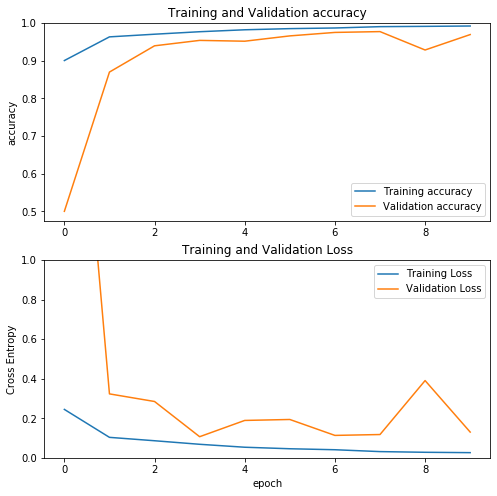

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Loading model

In [39]:
darknetv2 = Sequential()
darknetv2.add(InputLayer(input_shape=(IMG_SIZE,IMG_SIZE,1)))
darknetv2.add(Conv2D(64,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(MaxPooling2D(pool_size=(2, 2)))
darknetv2.add(Conv2D(192,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(MaxPooling2D(pool_size=(2, 2)))

darknetv2.add(Conv2D(128,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(256,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(MaxPooling2D(pool_size=(2, 2)))

darknetv2.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(256,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(512,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(512,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(MaxPooling2D(pool_size=(2, 2)))

darknetv2.add(Conv2D(512,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(512,1, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(Conv2D(1024,3, strides=(1,1), padding = "same"))
darknetv2.add(BatchNormalization())
darknetv2.add(LeakyReLU(alpha=0.1))
darknetv2.add(GlobalAveragePooling2D())

darknetv2.add(Dense(512, activation = "relu"))
darknetv2.add(Dense(512, activation = "relu"))
darknetv2.add(Dense(1, activation = "sigmoid"))

In [40]:
darknetv2.load_weights("face_classifier_BN_GRAYSCALE.h5") 
darknetv2.compile(optimizer=Adam(lr = 1e-4), loss="binary_crossentropy", metrics=["accuracy"])

In [41]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory="./",
            x_col="image_path",
            y_col="face",
            class_mode="raw",
            shuffle=False,
            color_mode = 'grayscale',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE)

STEP_SIZE_TEST = test_generator.n / test_generator.batch_size 


#CHANGE PARALLEL MODEL
pred=darknetv2.predict_generator(test_generator,  steps=STEP_SIZE_TEST,  verbose=1)


Found 4099 validated image filenames.
33/32 [==============================] - 43s 1s/step


In [ ]:
img = Image.open(test_generator.filenames[1])
img1 = ImageDraw.Draw(img)
font = ImageFont.truetype("arial.ttf", 50)
# get a drawing context
# draw text, half opacity
img1.text((0,0), str(pred[1]), font = font,fill=(0,0,0,0))
img.save("./dataset/FACE_CLASSIFIER/testlabel3" + ".jpg")
img.show()

KeyboardInterrupt: 

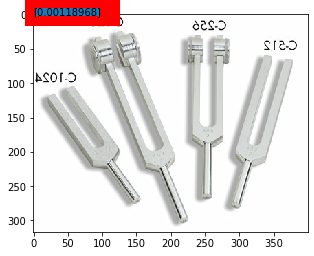

In [53]:
count = 0
for el in zip(pred,test_generator.labels,test_generator.filenames):
    count = count +1
    print(count) if count % 1000 == 0 else 0
    #print(el)
    img = Image.open(el[2])
    plt.imshow(img)
    #img1 = ImageDraw.Draw(img)
    plt.text(0, 0, str(el[0]), bbox=dict(fill=True, edgecolor='red', linewidth=10))
    #font = ImageFont.truetype(50,encoding="unic")
    #text_width, text_height = font.getsize(str(el[0]))
    # get a drawing context
    # draw text, half opacity
    #img1.text((0,0), str(el[0]), font = font, fill=(0,0,0,0))
    #img.show() 
    #plt.show()
    plt.savefig("/home/lorenzo.stacchio/ML/Machine_learning_project/dataset/results/output"+ str(count) + ".png")